In [1]:
!pip install xgboost 

                                              0.0/70.9 MB ? eta -:--:--
                                              0.1/70.9 MB 2.6 MB/s eta 0:00:28
                                              0.2/70.9 MB 2.9 MB/s eta 0:00:25
                                              0.4/70.9 MB 3.4 MB/s eta 0:00:21
                                              0.7/70.9 MB 4.6 MB/s eta 0:00:16
                                              1.2/70.9 MB 6.0 MB/s eta 0:00:12
                                              1.3/70.9 MB 6.1 MB/s eta 0:00:12
     -                                        1.8/70.9 MB 6.4 MB/s eta 0:00:11
     -                                        2.7/70.9 MB 8.1 MB/s eta 0:00:09
     -                                        2.7/70.9 MB 8.1 MB/s eta 0:00:09
     -                                        3.2/70.9 MB 7.8 MB/s eta 0:00:09
     --                                       4.1/70.9 MB 9.4 MB/s eta 0:00:08
     --                                       4.6/70.9 MB 9

In [3]:
!pip install seaborn

  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

In [2]:
# load the training dataset
df = pd.read_csv('Data/train.csv')

# overview of the data
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [3]:
# let's see with how much null data we're dealing with
print(df.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


The 'Cabin' column has $ \frac{687}{891} \approx 77\% $ null data so I'll discard this column

In [4]:
df.drop(columns='Cabin', axis=1, inplace=True)

# don't forget to drop the ID
df.drop(columns='PassengerId', axis=1, inplace=True)


Now I have to fill the missing 'Age' values. Let's look at the distribution of the 'Age' column to choose the way in which we'll fill the missing data

<Axes: >

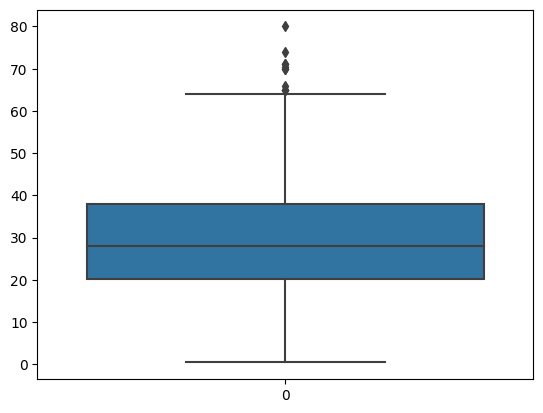

In [5]:
sns.boxplot(df.Age)

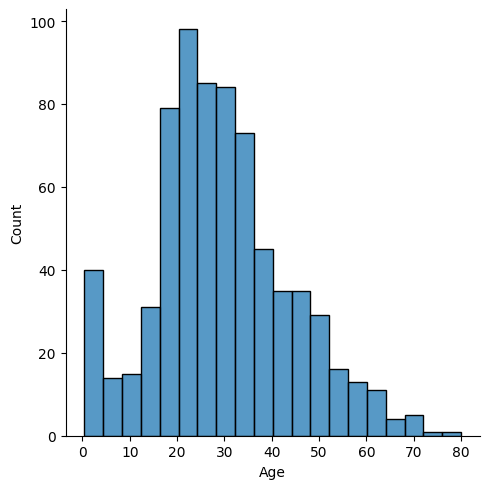

In [6]:
sns.displot(df.Age)

We can't quite call the distribution even, so let's fill the missing fields with the median

In [7]:
df['Age'] = df['Age'].fillna(df['Age'].median())

Let's look at the dataset now:

In [8]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Let's ignore the 'Name' column for now and see how the model will do to decide if we'll need to try to engineer additional features based off of it (Mr., Mrs, Miss. one-hot columns for example)

In [9]:
df1 = df.drop(columns='Name', axis=1)

The 'Ticket' field is the ticket number so I will try to make the first model without using it

In [10]:
df1.drop(columns='Ticket', axis=1, inplace=True)

In [11]:
# one-hot encode the 'Embarked' and 'Sex' columns
df1['Sex'] = pd.get_dummies(df1['Sex'], drop_first=True)
emb = pd.get_dummies(df1['Embarked'], prefix='Embarked')

df1 = pd.concat([df1, emb], axis=1)
print(df1)

     Survived  Pclass    Sex   Age  SibSp  Parch     Fare Embarked   
0           0       3   True  22.0      1      0   7.2500        S  \
1           1       1  False  38.0      1      0  71.2833        C   
2           1       3  False  26.0      0      0   7.9250        S   
3           1       1  False  35.0      1      0  53.1000        S   
4           0       3   True  35.0      0      0   8.0500        S   
..        ...     ...    ...   ...    ...    ...      ...      ...   
886         0       2   True  27.0      0      0  13.0000        S   
887         1       1  False  19.0      0      0  30.0000        S   
888         0       3  False  28.0      1      2  23.4500        S   
889         1       1   True  26.0      0      0  30.0000        C   
890         0       3   True  32.0      0      0   7.7500        Q   

     Embarked_C  Embarked_Q  Embarked_S  
0         False       False        True  
1          True       False       False  
2         False       False      

In [12]:
# double-check the types
print(df1.dtypes)

Survived        int64
Pclass          int64
Sex              bool
Age           float64
SibSp           int64
Parch           int64
Fare          float64
Embarked       object
Embarked_C       bool
Embarked_Q       bool
Embarked_S       bool
dtype: object


Time to make the cross validation and the train sets

In [13]:
# drop the original'Embarked' column
df1.drop(columns='Embarked', axis=1, inplace=True)

In [14]:
Y = df1.pop('Survived')

In [15]:
model = XGBClassifier()

model.fit(np.array(df1), np.array(Y))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [16]:
X_test = pd.read_csv('Data/test.csv')

X_test.drop(columns=['Name', 'Ticket'], axis=1, inplace=True)

X_test['Sex'] = pd.get_dummies(X_test['Sex'], drop_first=True)
emb_test = pd.get_dummies(X_test['Embarked'], prefix='Embarked')

X_test = pd.concat([X_test, emb_test], axis=1)

X_test.drop(columns=['Cabin', 'Embarked', 'PassengerId'], axis=1, inplace=True)




In [17]:
X_test['Age'] = X_test['Age'].fillna(X_test['Age'].median())


In [18]:
y_test = model.predict(X_test)

Now let's see how the model did by making submissions:

In [21]:
sub = pd.read_csv('Data/gender_submission.csv')

submission_df = pd.DataFrame({
    'PassengerId': sub.PassengerId,
    'Survived': y_test
})

submission_df.to_csv('Data/gender_submission.csv', index=False)

     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]


### Accuracy on test set: 0.72727